<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Test_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Codes for MGTF 405

## Test Code for Assignments

We will use the Goyal Welch dataset obtained from the following page:
https://drive.google.com/file/d/1ACbhdnIy0VbCWgsnXkjcddiV8HF4feWv/view?usp=sharing

We will be testing the following procedures:
* ARIMA, and Lag Selection
* ADF tests
* ACF, PACF, Ljung Box Test
* Lasso, Elastic Net
* Trends
* Seasonality

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/PredictorData2020.xlsx', parse_dates=True)

In [ ]:
df['yyyymm'] = pd.to_datetime(df['yyyymm'],format='%Y%m', errors='coerce')

In [ ]:
df.set_index('yyyymm',inplace=True)
df.head()


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
1927-01-01,13.21,0.6967,1.229,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,0.0025,-0.011299,0.0075,0.0056,0.000470,NaN,-0.002910,-0.005579
1927-02-01,13.84,0.7033,1.218,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,0.0026,-0.005714,0.0088,0.0069,0.000287,NaN,0.045522,0.040566
1927-03-01,13.93,0.7100,1.208,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,0.0030,-0.005747,0.0253,0.0083,0.000924,NaN,0.007324,0.002610
1927-04-01,14.17,0.7167,1.197,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.0025,0.000000,-0.0005,0.0055,0.000603,NaN,0.013021,0.010907
1927-05-01,14.91,0.7233,1.186,0.434783,0.0333,0.0457,0.0550,0.0327,0.055275,0.0030,0.005780,0.0109,-0.0011,0.000392,NaN,0.062353,0.057096


In [ ]:
! pip install statsmodels -U

In [ ]:
!pip install pmdarima
import pmdarima
import itertools
from statsmodels.tsa.arima.model import ARIMA

The function

```
AIC_PDQ
```

takes 4 arguments, the series, max lag on the AR parameters labeled 'p', the integration order labeled 'ii', and the max lags on the MA parameter labeled 'q'. If we know the series does not need to be differenced, then we set ii=1, if the integration order is 1, then we set ii=2.

The output of the function is the combination of p,d,q that minimizes AIC,

We create a similar function called:
```
BIC_PDQ
```
which takes the same arguments, however, returns the combination of p,d,q that minimizes BIC.


In [ ]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any value between 0 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df


In [ ]:
AIC_PDQ(df['Index'],12,1,12)

In [ ]:
def BIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order,
# cannot be 0.
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.bic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])
    print(ans_df.loc[ans_df['bic'].idxmin()])
    return ans_df


In [ ]:
BIC_PDQ(df['Index'],12,1,12)

We will now shift gears and focus on the Autocorrelation (ACF) and Partial Autocorrelation functions (PACF).

In [ ]:
import statsmodels.api as sm

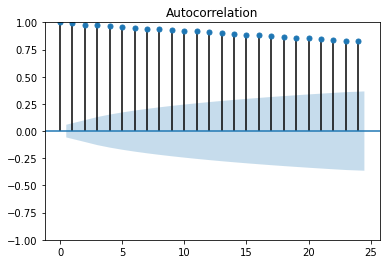

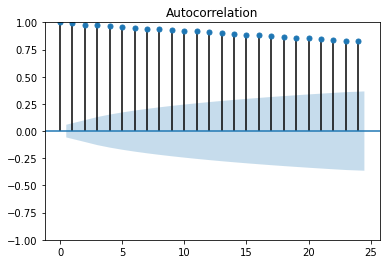

In [ ]:
sm.graphics.tsa.plot_acf(df['Index'].squeeze(), lags=24)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


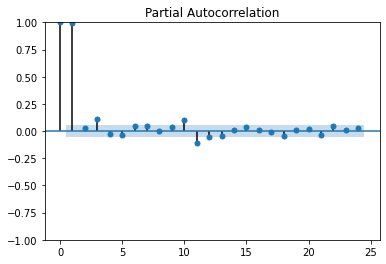

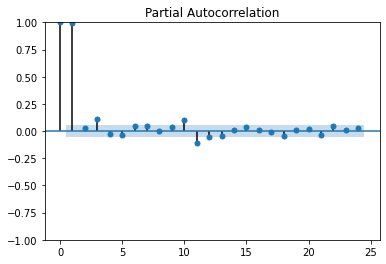

In [ ]:
sm.graphics.tsa.plot_pacf(df['Index'].squeeze(), lags=24)

## Ljung-Box Test

To use theLjung Box test, we first need run a regression and collect the
residuals. We then implement the Ljung-Box test.

We will run our model defined in AIC section above ARMA(10,11). 

In [ ]:
res = ARIMA(df['Index'],order=(10,0,11)).fit()

In [ ]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Index   No. Observations:                 1128
Model:               ARIMA(10, 0, 11)   Log Likelihood               -5647.406
Date:                Wed, 29 Dec 2021   AIC                          11340.812
Time:                        07:07:11   BIC                          11456.461
Sample:                             0   HQIC                         11384.509
                               - 1128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        486.8684      0.001   3.48e+05      0.000     486.866     486.871
ar.L1          0.1237      0.052      2.401      0.016       0.023       0.225
ar.L2          0.3177      0.042      7.607      0.000       0.236       0.400
ar.L3         -0.6905      0.059    -11.626      0.000      -0.807      -0.574
ar.L4         -0.1282      0.051     -2.539      0.011      -0.227      -0.029
ar.L5          0.0099      0.044      0.223      0.823      -0.077       0.096
ar.L6          0.0891      0.054      1.645      0.100      -0.017       0.195
ar.L7          0.7965      0.044     18.232      0.000       0.711       0.882
ar.L8         -0.1699      0.061     -2.764      0.006      -0.290      -0.049
ar.L9         -0.1010      0.040     -2.501      0.012      -0.180      -0.022
ar.L10         0.7523      0.046     16.313      0.000       0.662       0.843
ma.L1          0.9439      0.057     16.456      0.000       0.831       1.056
ma.L2          0.4803      0.075      6.371      0.000       0.333       0.628
ma.L3          1.2464      0.066     18.874      0.000       1.117       1.376
ma.L4          1.4771      0.050     29.491      0.000       1.379       1.575
ma.L5          1.3923      0.070     20.007      0.000       1.256       1.529
ma.L6          1.2583      0.083     15.241      0.000       1.097       1.420
ma.L7          0.6076      0.076      7.954      0.000       0.458       0.757
ma.L8          0.7715      0.053     14.486      0.000       0.667       0.876
ma.L9          0.8118      0.034     23.910      0.000       0.745       0.878
ma.L10         0.1264      0.033      3.814      0.000       0.061       0.191
ma.L11         0.1089      0.023      4.669      0.000       0.063       0.155
sigma2      1343.4589     25.254     53.198      0.000    1293.962    1392.956
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15494.90
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):            2633.28   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+20. Standard errors may be unstable.
"""

We now implement the Ljung Box Test.

In [ ]:
sm.stats.acorr_ljungbox(res.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,9.617836,0.649448


## Augmented Dickey Fuler Test

It is simple to implement the ADF test in python using Statsmodels. After importing the necessary package, we define a function that follows the procedure defined below:
1. Run ADF test with lag selection that minimizes AIC
2. Return the follwing:
  * Test Statistic
  * P-Value
  * Number of Lags Selected
  * Number of Observations
  

In [ ]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
adf_test(df['Index'])

Results of Dickey-Fuller Test:
Test Statistic                    4.364641
p-value                           1.000000
#Lags Used                       22.000000
Number of Observations Used    1105.000000
Critical Value (1%)              -3.436282
Critical Value (5%)              -2.864159
Critical Value (10%)             -2.568165
dtype: float64


## Lasso Regression

We import the necessary packages

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV


### Lasso with $\alpha=1$

In [ ]:
df

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
1927-01-01,13.21,0.696700,1.229000,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,0.0025,-0.011299,0.0075,0.0056,0.000470,NaN,-0.002910,-0.005579
1927-02-01,13.84,0.703300,1.218000,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,0.0026,-0.005714,0.0088,0.0069,0.000287,NaN,0.045522,0.040566
1927-03-01,13.93,0.710000,1.208000,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,0.0030,-0.005747,0.0253,0.0083,0.000924,NaN,0.007324,0.002610
1927-04-01,14.17,0.716700,1.197000,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.0025,0.000000,-0.0005,0.0055,0.000603,NaN,0.013021,0.010907
1927-05-01,14.91,0.723300,1.186000,0.434783,0.0333,0.0457,0.0550,0.0327,0.055275,0.0030,0.005780,0.0109,-0.0011,0.000392,NaN,0.062353,0.057096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,3500.31,59.128628,98.556667,0.235975,0.0010,0.0225,0.0327,0.0065,-0.008504,0.0001,0.003153,-0.0349,-0.0488,0.000743,NaN,0.072068,0.070308
2020-09-01,3363.00,58.851237,98.220000,0.241482,0.0011,0.0231,0.0336,0.0068,-0.005698,0.0001,0.001393,0.0080,0.0041,0.004907,NaN,-0.038151,-0.039366
2020-10-01,3269.96,58.660440,96.856667,0.253146,0.0010,0.0235,0.0344,0.0079,-0.001895,0.0001,0.000415,-0.0238,-0.0190,0.003661,NaN,-0.026409,-0.027507


In [ ]:
len(df)

1128

We have in total 1128 observations, we need to split our data set into Train and Test sets. Suppose we want to forecast the last 10 years. We will set the training set the first 84 years , and the test set to be last 10 years.

In [ ]:
X_train = df.iloc[:1008,1:].drop(columns=['csp'])
y_train = df.iloc[:1008,0]
X_test = df.iloc[1008:,1:].drop(columns=['csp'])
y_test = df.iloc[1008:,0]

In [ ]:
X_train

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,
1927-01-01,0.696700,1.229000,0.443706,0.0323,0.0466,0.0561,0.035100,0.050824,0.0025,-0.011299,0.007500,0.005600,0.000470,-0.002910,-0.005579
1927-02-01,0.703300,1.218000,0.428501,0.0329,0.0467,0.0559,0.034700,0.051668,0.0026,-0.005714,0.008800,0.006900,0.000287,0.045522,0.040566
1927-03-01,0.710000,1.208000,0.469765,0.0320,0.0462,0.0554,0.033100,0.046357,0.0030,-0.005747,0.025300,0.008300,0.000924,0.007324,0.002610
1927-04-01,0.716700,1.197000,0.456754,0.0339,0.0458,0.0548,0.033300,0.050514,0.0025,0.000000,-0.000500,0.005500,0.000603,0.013021,0.010907
1927-05-01,0.723300,1.186000,0.434783,0.0333,0.0457,0.0550,0.032700,0.055275,0.0030,0.005780,0.010900,-0.001100,0.000392,0.062353,0.057096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-01,22.247667,70.273333,0.413982,0.0016,0.0449,0.0566,0.032708,0.011218,0.0001,0.001381,0.070213,0.047319,0.002705,-0.045434,-0.047840
2010-09-01,22.353000,71.860000,0.384306,0.0015,0.0453,0.0566,0.034063,0.003338,0.0001,0.000582,-0.015330,-0.014395,0.002337,0.090383,0.088751
2010-10-01,22.478333,73.690000,0.372887,0.0013,0.0468,0.0572,0.036716,0.007232,0.0001,0.001245,-0.031739,-0.020275,0.001080,0.038726,0.037081


In [ ]:
y_train

yyyymm
1927-01-01      13.21
1927-02-01      13.84
1927-03-01      13.93
1927-04-01      14.17
1927-05-01      14.91
               ...   
2010-08-01    1049.33
2010-09-01    1141.20
2010-10-01    1183.26
2010-11-01    1180.55
2010-12-01    1257.64
Name: Index, Length: 1008, dtype: float64

We know that regularization methods work best when we standardize our variables.We will follow the following standardization:
$$ z = \frac{x-\bar{x}}{\sigma_x} $$
Where $x$ is the observation, $\bar{x}$ is the sample mean of the variable, and $\sigma_x$ is the standard deviation of the variable.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train,X_test

(array([[-0.79735476, -0.69985784, -0.54438817, ...,         nan,
         -0.21790302, -0.20640263],
        [-0.79643681, -0.70044785, -0.60146299, ...,         nan,
          0.6485307 ,  0.61803629],
        [-0.79550495, -0.70098423, -0.44656765, ...,         nan,
         -0.03481988, -0.06009576],
        ...,
        [ 2.23210804,  3.18679328, -0.81022199, ...,         nan,
          0.52695233,  0.55577235],
        [ 2.24953982,  3.28495052, -0.79592974, ...,         nan,
         -0.16675638, -0.15266089],
        [ 2.2669716 ,  3.38310776, -0.86572845, ...,         nan,
          1.03373161,  1.05902937]]),
 array([[ 2.29951711,  3.4539097 , -0.90126922, ...,         nan,
          0.25186249,  0.29203051],
        [ 2.33206262,  3.52471164, -0.93706359, ...,         nan,
          0.4157142 ,  0.43374574],
        [ 2.36460812,  3.59551358, -0.8801067 , ...,         nan,
         -0.15466295, -0.12221677],
        ...,
        [ 7.26443707,  4.42940311, -1.25969898, ...,  

In [ ]:
reg = Lasso(alpha=1)
res =reg.fit(X_train, y_train)

Let's get the coefficients in our Lasso

In [ ]:
coef=res.coef_
coef_list=list(zip(df.iloc[:1008,1:].drop(columns=['csp']).columns,np.round(coef,3)))
coef_list

[('D12', 193.343),
 ('E12', 196.436),
 ('b/m', -49.413),
 ('tbl', -2.798),
 ('AAA', 105.967),
 ('BAA', 25.595),
 ('lty', -171.457),
 ('ntis', -2.534),
 ('Rfree', -0.0),
 ('infl', 2.058),
 ('ltr', -10.227),
 ('corpr', -0.0),
 ('svar', 1.193),
 ('CRSP_SPvw', -0.0),
 ('CRSP_SPvwx', -0.0)]

We can also get the $R^2$ of the training set and test set

In [ ]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 94.24
R squared test set 80.4


Let's now get the RMSE of the training and test sets

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
print('RMSE training set', round(rmse_train, 2))

# Test data
pred = reg.predict(X_test)
rmse_test =np.sqrt(mean_squared_error(y_test, pred))
print('RMSE test set', round(rmse_test, 2))

RMSE training set 100.97
RMSE test set 280.42


We obtained these results without doing any cross validation. We know that the coefficients are going to be a function of the $\alpha$ we choose. Let's plot the values of the coefficients based on the value of $\alpha$

No handles with labels found to put in legend.


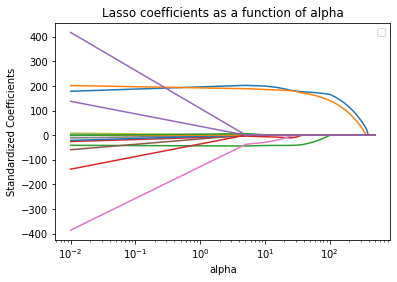

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

As we can see,  coefficients are sensitive to the $\alpha$ we select.

### Cross Validation to Find Best $\alpha$

Let's now apply 5 Fold Cross Validation to find the best value for $\alpha$.

In [ ]:
model = LassoCV(cv=5, random_state=0, max_iter=10000)
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

We then ask for the best $\alpha$ value based on the cross validation.

In [ ]:
model.alpha_

0.3937234197628315

We will now use this $\alpha$ value to run our new Lasso regression.

In [ ]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.3937234197628315)

In [ ]:
coef=lasso_best.coef_
coef_list_best=list(zip(df.iloc[:1008,1:].drop(columns=['csp']).columns,np.round(coef,3)))
coef_list_best

[('D12', 183.794),
 ('E12', 200.416),
 ('b/m', -49.073),
 ('tbl', -8.69),
 ('AAA', 248.481),
 ('BAA', -0.0),
 ('lty', -282.914),
 ('ntis', -7.096),
 ('Rfree', -0.0),
 ('infl', 3.675),
 ('ltr', -16.268),
 ('corpr', -0.0),
 ('svar', -0.638),
 ('CRSP_SPvw', -0.652),
 ('CRSP_SPvwx', -0.0)]

In [ ]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 94.44
R squared test set 79.52


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Training data
pred_train = lasso_best.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
print('RMSE training set', round(rmse_train, 2))

# Test data
pred = lasso_best.predict(X_test)
rmse_test =np.sqrt(mean_squared_error(y_test, pred))
print('RMSE test set', round(rmse_test, 2))

RMSE training set 99.21
RMSE test set 286.64


## Elastic Net Regression

For the Elastic Net we will use the same tranining and test samples.

In [ ]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=1, l1_ratio =0.5)
enet_res =enet.fit(X_train, y_train)

In [ ]:
coef_enet=enet_res.coef_
coef_list_enet=list(zip(df.iloc[:1008,1:].drop(columns=['csp']).columns,np.round(coef_enet,3)))
coef_list_enet

[('D12', 137.687),
 ('E12', 145.206),
 ('b/m', -77.987),
 ('tbl', -11.533),
 ('AAA', 5.324),
 ('BAA', 4.545),
 ('lty', -5.574),
 ('ntis', -23.879),
 ('Rfree', -7.559),
 ('infl', -0.912),
 ('ltr', -0.345),
 ('corpr', -0.0),
 ('svar', 9.101),
 ('CRSP_SPvw', -2.611),
 ('CRSP_SPvwx', -0.005)]

We can get the $R^2$ values for the test and train sets

In [ ]:
print('R squared training set', round(enet.score(X_train, y_train)*100, 4))
print('R squared test set', round(enet.score(X_test, y_test)*100, 4))

R squared training set 90.0923
R squared test set 31.7685


Let's now get the RMSE for both the training and test samples. 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Training data
pred_train = enet.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
print('RMSE training set', round(rmse_train, 2))

# Test data
pred = enet.predict(X_test)
rmse_test =np.sqrt(mean_squared_error(y_test, pred))
print('RMSE test set', round(rmse_test, 2))

RMSE training set 132.42
RMSE test set 523.19


We can see that the Elastic Net performs poorly compared to the Lasso.

Now let's tune the hyperparameters of the Elastic Net using 5 fold cross validation.

In [ ]:
from sklearn.linear_model import ElasticNetCV
enet_best = ElasticNetCV(cv=5,random_state=0, max_iter=10000)
enet_res_best =enet_best.fit(X_train, y_train)

In [ ]:
enet_best_alpha=enet_best.alpha_

In [ ]:
enet_best.l1_ratio_

0.5

In [ ]:
enet_best = ElasticNet(alpha=enet_best_alpha, l1_ratio =0.5)
enet_res_best =enet.fit(X_train, y_train)

In [ ]:
coef_enet_best=enet_res_best.coef_
coef_list_enet_best=list(zip(df.iloc[:1008,1:].drop(columns=['csp']).columns,np.round(coef_enet_best,3)))
coef_list_enet_best

[('D12', 137.687),
 ('E12', 145.206),
 ('b/m', -77.987),
 ('tbl', -11.533),
 ('AAA', 5.324),
 ('BAA', 4.545),
 ('lty', -5.574),
 ('ntis', -23.879),
 ('Rfree', -7.559),
 ('infl', -0.912),
 ('ltr', -0.345),
 ('corpr', -0.0),
 ('svar', 9.101),
 ('CRSP_SPvw', -2.611),
 ('CRSP_SPvwx', -0.005)]

In [ ]:
print('R squared training set', round(enet_res_best.score(X_train, y_train)*100, 4))
print('R squared test set', round(enet_res_best.score(X_test, y_test)*100, 4))

R squared training set 90.0923
R squared test set 31.7685


We can also have a more hands on approach to hyperparameter tuning.


In [ ]:
from sklearn.model_selection import RepeatedKFold
from numpy import arange
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
model.fit(X_train, y_train)


In [ ]:
model.alpha_

0.0001

In [ ]:
model.l1_ratio_

0.14

In [ ]:
print('R squared training set', round(model.score(X_train, y_train)*100, 4))
print('R squared test set', round(model.score(X_test, y_test)*100, 4))

R squared training set 94.5337
R squared test set 78.6933


We can see that sometimes, it is better to do hypertuning with a more hands-on approach. Compared to previous Rsquare values, the model we hand tuned is performing better in the test set.

## CO2 Data: Trend and Seasonality

### Deterministic Trend and Seasonality

We will introduce the concept of trend and seasonality using the Keeling CO2 database.

In [ ]:
! pip install statsmodels -U

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Keeling_CO2_data_2022.csv')

In [ ]:
df.head()

,Yr,month,CO2_ppm
0,1964,5,322.25
1,1964,6,321.89
2,1964,7,320.44
3,1964,8,318.69
4,1964,9,316.71


We are now going to concatenate the 2 columns 'Yr' and 'month' to create a 'Date' variable. We then use this new column to set it as our time index.

In [ ]:
df['Date']=pd.to_datetime(df.Yr.astype(str) + '/' + df.month.astype(str))

In [ ]:
df.set_index(df['Date'],inplace=True)

In [ ]:
df.asfreq('MS')

,Yr,month,CO2_ppm,Date
Date,,,,
1964-05-01,1964,5,322.25,1964-05-01
1964-06-01,1964,6,321.89,1964-06-01
1964-07-01,1964,7,320.44,1964-07-01
1964-08-01,1964,8,318.69,1964-08-01
1964-09-01,1964,9,316.71,1964-09-01
...,...,...,...,...
2021-05-01,2021,5,418.95,2021-05-01
2021-06-01,2021,6,418.70,2021-06-01
2021-07-01,2021,7,416.65,2021-07-01


We then plot the CO2 data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

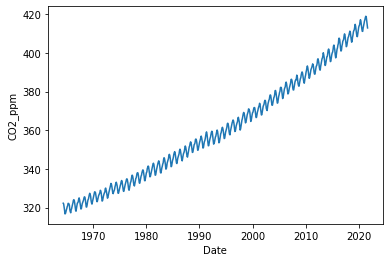

In [ ]:
sns.lineplot(data= df, x='Date', y='CO2_ppm')

By visual inspection we can see that our data is trending and definitely has a seasonal component.

Let's create a 'trend' variable and estimate a simple linear trend model

In [ ]:
df['trend'] = [i for i in range(1,len(df)+1)]

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_trend = smf.ols(formula = 'CO2_ppm~ 1 + trend', data= df).fit()

In [ ]:
model_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CO2_ppm   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 3.474e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:07:34   Log-Likelihood:                -1917.6
No. Observations:                 689   AIC:                             3839.
Df Residuals:                     687   BIC:                             3848.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    312.2877      0.299   1044.926      0.000     311.701     312.874
trend          0.1399      0.001    186.389      0.000       0.138       0.141
==============================================================================
Omnibus:                       19.227   Durbin-Watson:                   0.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.045
Skew:                           0.374   Prob(JB):                     7.32e-05
Kurtosis:                       2.676   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df['trend_fit'] =model_trend.predict()


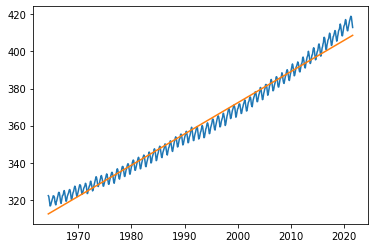

In [ ]:
plt.plot(df['CO2_ppm'])
plt.plot(df['trend_fit'])

The linear trend model is somewhat capturing the trend in the CO2 data. We can also fit a quadratic trend. 

In [ ]:
df['trend2'] = [i**2 for i in range(1,len(df)+1)]

In [ ]:
model_trend_2 = smf.ols(formula = 'CO2_ppm~ 1 + trend + trend2', data= df).fit()

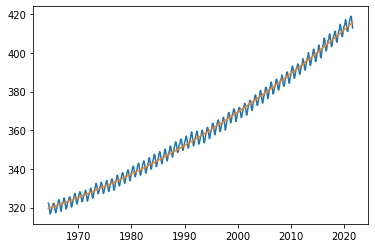

In [ ]:
df['trend2_fit'] = model_trend_2.predict()
plt.plot(df['CO2_ppm'])
plt.plot(df['trend2_fit'])

We can see that the quadratic trend is capturing the CO2 in a much better way. However, we still need account for the seasonality in the data.

In [ ]:
season=pd.DataFrame(pd.get_dummies(df.month))
season.head(24)
season.columns= ['Jan', 'Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov','Dec']
season

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,
1964-05-01,0,0,0,0,1,0,0,0,0,0,0,0
1964-06-01,0,0,0,0,0,1,0,0,0,0,0,0
1964-07-01,0,0,0,0,0,0,1,0,0,0,0,0
1964-08-01,0,0,0,0,0,0,0,1,0,0,0,0
1964-09-01,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0,0,0,0,1,0,0,0,0,0,0,0
2021-06-01,0,0,0,0,0,1,0,0,0,0,0,0
2021-07-01,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
df=pd.concat([df,season],axis=1)

In [ ]:
df

,Yr,month,CO2_ppm,Date,trend,trend_fit,trend2,trend2_fit,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,,,,,,,,,
1964-05-01,1964,5,322.25,1964-05-01,1,312.427571,1,319.544116,0,0,0,0,1,0,0,0,0,0,0,0
1964-06-01,1964,6,321.89,1964-06-01,2,312.567452,4,319.621934,0,0,0,0,0,1,0,0,0,0,0,0
1964-07-01,1964,7,320.44,1964-07-01,3,312.707333,9,319.699933,0,0,0,0,0,0,1,0,0,0,0,0
1964-08-01,1964,8,318.69,1964-08-01,4,312.847214,16,319.778113,0,0,0,0,0,0,0,1,0,0,0,0
1964-09-01,1964,9,316.71,1964-09-01,5,312.987095,25,319.856473,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,2021,5,418.95,2021-05-01,685,408.106142,469225,414.975520,0,0,0,0,1,0,0,0,0,0,0,0
2021-06-01,2021,6,418.70,2021-06-01,686,408.246023,470596,415.176921,0,0,0,0,0,1,0,0,0,0,0,0
2021-07-01,2021,7,416.65,2021-07-01,687,408.385904,471969,415.378504,0,0,0,0,0,0,1,0,0,0,0,0


Let's now model the CO2 as function of trend and seasonal components.

In [ ]:
model_trs = smf.ols(formula='CO2_ppm ~ 1 + trend+ trend2 + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec', data = df).fit()

In [ ]:
model_trs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CO2_ppm   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.331e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:07:50   Log-Likelihood:                -777.08
No. Observations:                 689   AIC:                             1582.
Df Residuals:                     675   BIC:                             1646.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    319.5349      0.129   2470.248      0.000     319.281     319.789
trend          0.0776      0.001    133.954      0.000       0.076       0.079
trend2       9.02e-05   8.13e-07    110.922      0.000    8.86e-05    9.18e-05
Feb            0.6523      0.141      4.612      0.000       0.375       0.930
Mar            1.3266      0.141      9.378      0.000       1.049       1.604
Apr            2.5615      0.141     18.109      0.000       2.284       2.839
May            3.0303      0.141     21.515      0.000       2.754       3.307
Jun            2.2967      0.141     16.307      0.000       2.020       2.573
Jul            0.6337      0.141      4.499      0.000       0.357       0.910
Aug           -1.5175      0.141    -10.774      0.000      -1.794      -1.241
Sep           -3.3269      0.141    -23.621      0.000      -3.603      -3.050
Oct           -3.4388      0.141    -24.310      0.000      -3.717      -3.161
Nov           -2.1445      0.141    -15.161      0.000      -2.422      -1.867
Dec           -0.9658      0.141     -6.828      0.000      -1.244      -0.688
==============================================================================
Omnibus:                       30.827   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.161
Skew:                           0.386   Prob(JB):                     3.44e-06
Kurtosis:                       2.470   Cond. No.                     2.66e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
df['trs_fit'] =model_trs.predict()


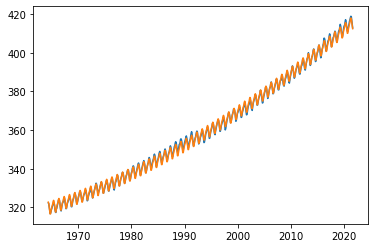

In [ ]:
plt.plot(df['CO2_ppm'])
plt.plot(df['trs_fit'])


We can see that the model with the quadratic trend and seasonal dummies capture the data really well.

In [ ]:
residual_trend = df['CO2_ppm']-df['trend_fit']
residual_trend_2 = df['CO2_ppm']-df['trend2_fit']
residual_trs = df['CO2_ppm']-df['trs_fit']

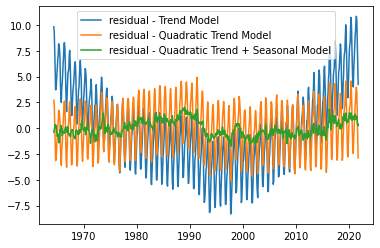

In [ ]:
plt.plot(residual_trend, label = 'residual - Trend Model')
plt.plot(residual_trend_2, label = 'residual - Quadratic Trend Model') 
plt.plot(residual_trs, label = 'residual - Quadratic Trend + Seasonal Model')
plt.legend()

It is clear that the quadratic trend with seasonal components have the smallest residuals, and visually they are centered around zero. For certain periods we see that the model is underpredicting and for some others we are overpredicting. Furthermore, these over and underpredictions seem to be persistent.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

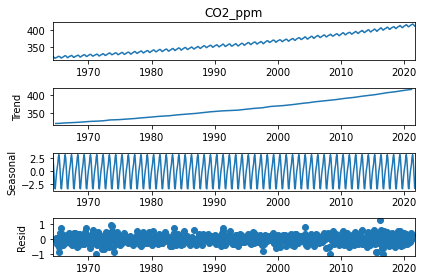

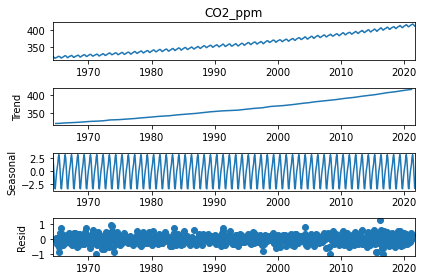

In [ ]:
season_decomp =seasonal_decompose(df['CO2_ppm'], model='additive')
season_decomp.plot()


In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
stl = STL(df['CO2_ppm'], seasonal = 13).fit()

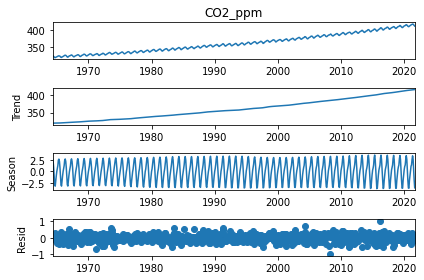

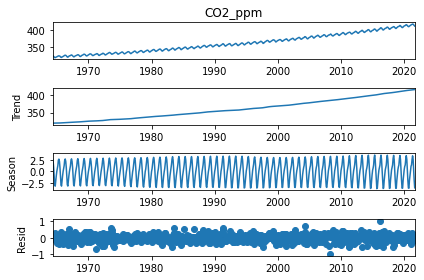

In [ ]:
stl.plot()

### Stochastic Trend and Seasonality

In [ ]:
! pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import itertools

In [ ]:
import statsmodels as sm

In [ ]:
def AIC_PDQS(df,ar,ii,ma,trend): 
# trend can take : 'n','c','t','ct'
# Define the p, d and q parameters to take any value between 0 and max lag length, ii needs to be between 1 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Need to Change 12 to frequency of data
# Generate all different combinations of seasonal p, d and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      for combs in pdqs:
        try:
          mod = sm.tsa.statespace.sarimax.SARIMAX(df,
                                          order=comb,
                                          seasonal_order=combs,
                                          trend = trend,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
          output = mod.fit()
          ans.append([comb,combs, output.aic])
          print('ARIMA {} x {}  : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
          continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [ ]:
AIC_PDQS(df['CO2_ppm'], 3,2,3, 'c')

In [ ]:
sarima = sm.tsa.statespace.sarimax.SARIMAX(df['CO2_ppm'],
                                          order=(1,1,1),
                                          seasonal_order=(1,1,2,12),
                                          trend = 'c',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit()

In [ ]:
df['sarima_fit']= sarima.predict()

In [ ]:
import matplotlib.pyplot as plt

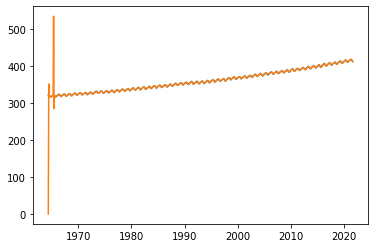

In [ ]:
plt.plot(df['CO2_ppm'])
plt.plot(df['sarima_fit'])